In [1]:
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F
import pandas as pd
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../plant_pathology/scripts/')
from dataset.dataloaders import GetLoaders
from dataset.dataset import ReadCSV
import os
from train.loss import loss_fn
from model.resnet32 import get_model
from model.vgg16 import get_vgg16
from train.train_script import train, eval_dataset
import torchvision
from dataset.resize_images import resize_images
import glob
# from kaggle.api.kaggle_api_extended import KaggleApi
import pickle
from metrics.metrics import generate_metrics
import matplotlib.pyplot as plt
import torchvision

In [2]:
# resize_images(folder_path='../../plant_path_data/train_images/', new_path='../../plant_path_data/train_images_224/', img_size=224)

In [3]:
temp = ReadCSV('../../plant_path_data/train.csv', '../../plant_path_data/train_images_224/')
temp.read_csv()
temp.check_paths()
temp.encode_labels()
temp.one_hot_encoder()
temp.split_datasets()

In [4]:
# temp.check_image_valids()

In [5]:
data_object = temp.get_object()
loader_object = GetLoaders(data_object.train, data_object.val, data_object.test)
loader_object.create_sets()
loader_object.create_loaders(batch_size=256)
train_loader, val_loader, test_loader = loader_object.return_loaders()

In [6]:
wandb_dict = {
    'model_name' : 'res32',
    'dataset_name' : 'plant_pathology',
    'epochs' : 50,
    'batch_size' : 256,
    'learning_rate' : 0.001,
    'optimizer' : 'Adam',
    'weights_path' : '../../weights/res32_horizontal_flip_random_rotate/',
    'horizontal_flip' : True,
    'random_rotation' : True,
    'normalize' : True,
    'fixed_metrics' : True
}

In [7]:
train(get_model(12), train_loader, val_loader, 50, wandb_dict=wandb_dict, save_path='../../weights/res32_horizontal_flip_random_rotate_norm/')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yashchks87. Use `wandb login --relogin` to force relogin


100%|██████████| 72/72 [00:22<00:00,  3.18batch/s, loss=1.44]


train loss: 1.7236989653772778


100%|██████████| 1/1 [00:01<00:00,  1.61s/batch, loss=1.6]


val loss: 1.6036969423294067
Weight saved for epoch 0.


100%|██████████| 72/72 [00:19<00:00,  3.67batch/s, loss=1.46]


train loss: 1.494701666964425


100%|██████████| 1/1 [00:01<00:00,  1.50s/batch, loss=1.54]


val loss: 1.5449867248535156
Weight saved for epoch 1.


100%|██████████| 72/72 [00:19<00:00,  3.66batch/s, loss=1.39]


train loss: 1.4092605362335842


100%|██████████| 1/1 [00:01<00:00,  1.52s/batch, loss=1.53]


val loss: 1.5317074060440063
Weight saved for epoch 2.


100%|██████████| 72/72 [00:19<00:00,  3.73batch/s, loss=0.933]


train loss: 1.1621846482157707


100%|██████████| 1/1 [00:01<00:00,  1.58s/batch, loss=1.37]


val loss: 1.3659029006958008
Weight saved for epoch 3.


100%|██████████| 72/72 [00:19<00:00,  3.67batch/s, loss=0.833]


train loss: 0.913807170258628


100%|██████████| 1/1 [00:01<00:00,  1.49s/batch, loss=0.79]


val loss: 0.7902387380599976
Weight saved for epoch 4.


100%|██████████| 72/72 [00:19<00:00,  3.69batch/s, loss=0.716]


train loss: 0.7599567141797807


100%|██████████| 1/1 [00:01<00:00,  1.59s/batch, loss=0.959]


val loss: 0.9590284824371338
Weight saved for epoch 5.


100%|██████████| 72/72 [00:19<00:00,  3.71batch/s, loss=0.699]


train loss: 0.6959603105982145


100%|██████████| 1/1 [00:01<00:00,  1.51s/batch, loss=0.795]


val loss: 0.7952249050140381
Weight saved for epoch 6.


100%|██████████| 72/72 [00:19<00:00,  3.73batch/s, loss=0.648]


train loss: 0.636406852139367


100%|██████████| 1/1 [00:01<00:00,  1.53s/batch, loss=0.65]


val loss: 0.6495378017425537
Weight saved for epoch 7.


100%|██████████| 72/72 [00:19<00:00,  3.71batch/s, loss=0.567]


train loss: 0.5876870589951674


100%|██████████| 1/1 [00:01<00:00,  1.57s/batch, loss=0.807]


val loss: 0.8070498108863831
Weight saved for epoch 8.


100%|██████████| 72/72 [00:19<00:00,  3.69batch/s, loss=0.512]


train loss: 0.577258569912778


100%|██████████| 1/1 [00:01<00:00,  1.54s/batch, loss=0.724]


val loss: 0.7240597009658813
Weight saved for epoch 9.


100%|██████████| 72/72 [00:19<00:00,  3.70batch/s, loss=0.468]


train loss: 0.5486546415421698


100%|██████████| 1/1 [00:01<00:00,  1.54s/batch, loss=0.617]


val loss: 0.6168860793113708
Weight saved for epoch 10.


100%|██████████| 72/72 [00:19<00:00,  3.65batch/s, loss=0.398]


train loss: 0.5161434784531593


100%|██████████| 1/1 [00:01<00:00,  1.52s/batch, loss=0.893]


val loss: 0.8926589488983154
Weight saved for epoch 11.


100%|██████████| 72/72 [00:19<00:00,  3.73batch/s, loss=0.533]


train loss: 0.5112903337511752


100%|██████████| 1/1 [00:01<00:00,  1.47s/batch, loss=0.531]


val loss: 0.5308836102485657
Weight saved for epoch 12.


100%|██████████| 72/72 [00:19<00:00,  3.75batch/s, loss=0.46] 


train loss: 0.4877026942041185


100%|██████████| 1/1 [00:01<00:00,  1.57s/batch, loss=0.64]


val loss: 0.6401498913764954
Weight saved for epoch 13.


100%|██████████| 72/72 [00:19<00:00,  3.65batch/s, loss=0.367]


train loss: 0.48171789902779794


100%|██████████| 1/1 [00:01<00:00,  1.55s/batch, loss=1.07]


val loss: 1.0688221454620361
Weight saved for epoch 14.


100%|██████████| 72/72 [00:19<00:00,  3.67batch/s, loss=0.45] 


train loss: 0.4722815350525909


100%|██████████| 1/1 [00:01<00:00,  1.54s/batch, loss=0.533]


val loss: 0.5333719849586487
Weight saved for epoch 15.


100%|██████████| 72/72 [00:19<00:00,  3.70batch/s, loss=0.455]


train loss: 0.45388111886050964


100%|██████████| 1/1 [00:01<00:00,  1.58s/batch, loss=0.624]


val loss: 0.6236137747764587
Weight saved for epoch 16.


100%|██████████| 72/72 [00:19<00:00,  3.66batch/s, loss=0.438]


train loss: 0.4452311827076806


100%|██████████| 1/1 [00:01<00:00,  1.62s/batch, loss=0.603]


val loss: 0.6030830144882202
Weight saved for epoch 17.


100%|██████████| 72/72 [00:19<00:00,  3.70batch/s, loss=0.362]


train loss: 0.43401897822817165


100%|██████████| 1/1 [00:01<00:00,  1.55s/batch, loss=0.576]


val loss: 0.5756622552871704
Weight saved for epoch 18.


100%|██████████| 72/72 [00:19<00:00,  3.69batch/s, loss=0.403]


train loss: 0.42786812740895486


100%|██████████| 1/1 [00:01<00:00,  1.55s/batch, loss=0.516]


val loss: 0.5161086320877075
Weight saved for epoch 19.


100%|██████████| 72/72 [00:19<00:00,  3.72batch/s, loss=0.312]


train loss: 0.4231203558544318


100%|██████████| 1/1 [00:01<00:00,  1.59s/batch, loss=0.538]


val loss: 0.5376979112625122
Weight saved for epoch 20.


100%|██████████| 72/72 [00:19<00:00,  3.74batch/s, loss=0.291]


train loss: 0.41993291800220806


100%|██████████| 1/1 [00:01<00:00,  1.57s/batch, loss=0.682]


val loss: 0.6815710663795471
Weight saved for epoch 21.


100%|██████████| 72/72 [00:19<00:00,  3.69batch/s, loss=0.404]


train loss: 0.4056587968435552


100%|██████████| 1/1 [00:01<00:00,  1.52s/batch, loss=0.675]


val loss: 0.6748356819152832
Weight saved for epoch 22.


100%|██████████| 72/72 [00:19<00:00,  3.70batch/s, loss=0.459]


train loss: 0.3947534602549341


100%|██████████| 1/1 [00:01<00:00,  1.50s/batch, loss=0.581]


val loss: 0.5808689594268799
Weight saved for epoch 23.


100%|██████████| 72/72 [00:19<00:00,  3.68batch/s, loss=0.339]


train loss: 0.4004218127164576


100%|██████████| 1/1 [00:01<00:00,  1.51s/batch, loss=0.64]


val loss: 0.6397271156311035
Weight saved for epoch 24.


100%|██████████| 72/72 [00:19<00:00,  3.68batch/s, loss=0.661]


train loss: 0.3882360052731302


100%|██████████| 1/1 [00:01<00:00,  1.51s/batch, loss=0.558]


val loss: 0.5581167936325073
Weight saved for epoch 25.


100%|██████████| 72/72 [00:19<00:00,  3.68batch/s, loss=0.553]


train loss: 0.3840407385594315


100%|██████████| 1/1 [00:01<00:00,  1.49s/batch, loss=0.514]


val loss: 0.5139197111129761
Weight saved for epoch 26.


100%|██████████| 72/72 [00:19<00:00,  3.72batch/s, loss=0.441]


train loss: 0.3672001096937392


100%|██████████| 1/1 [00:01<00:00,  1.62s/batch, loss=0.473]


val loss: 0.47311505675315857
Weight saved for epoch 27.


100%|██████████| 72/72 [00:19<00:00,  3.71batch/s, loss=0.288]


train loss: 0.3727367394086387


100%|██████████| 1/1 [00:01<00:00,  1.52s/batch, loss=0.496]


val loss: 0.4957495927810669
Weight saved for epoch 28.


100%|██████████| 72/72 [00:19<00:00,  3.68batch/s, loss=0.343]


train loss: 0.3526981953117583


100%|██████████| 1/1 [00:01<00:00,  1.57s/batch, loss=0.5]


val loss: 0.4998399019241333
Weight saved for epoch 29.


100%|██████████| 72/72 [00:19<00:00,  3.69batch/s, loss=0.387]


train loss: 0.356768022187882


100%|██████████| 1/1 [00:01<00:00,  1.54s/batch, loss=0.567]


val loss: 0.5671226978302002
Weight saved for epoch 30.


100%|██████████| 72/72 [00:19<00:00,  3.67batch/s, loss=0.375]


train loss: 0.352627158164978


100%|██████████| 1/1 [00:01<00:00,  1.51s/batch, loss=0.517]


val loss: 0.5173184275627136
Weight saved for epoch 31.


100%|██████████| 72/72 [00:19<00:00,  3.71batch/s, loss=0.448]


train loss: 0.3438439512004455


100%|██████████| 1/1 [00:01<00:00,  1.53s/batch, loss=0.656]


val loss: 0.6562769412994385
Weight saved for epoch 32.


100%|██████████| 72/72 [00:19<00:00,  3.69batch/s, loss=0.458]


train loss: 0.34591982141137123


100%|██████████| 1/1 [00:01<00:00,  1.56s/batch, loss=0.533]


val loss: 0.5330411195755005
Weight saved for epoch 33.


100%|██████████| 72/72 [00:19<00:00,  3.70batch/s, loss=0.421]


train loss: 0.337352367118001


100%|██████████| 1/1 [00:01<00:00,  1.51s/batch, loss=0.55]


val loss: 0.5499150156974792
Weight saved for epoch 34.


100%|██████████| 72/72 [00:19<00:00,  3.68batch/s, loss=0.325]


train loss: 0.330824652272794


100%|██████████| 1/1 [00:01<00:00,  1.56s/batch, loss=0.487]


val loss: 0.48711371421813965
Weight saved for epoch 35.


100%|██████████| 72/72 [00:19<00:00,  3.71batch/s, loss=0.544]


train loss: 0.3276290489981572


100%|██████████| 1/1 [00:01<00:00,  1.51s/batch, loss=0.605]


val loss: 0.6051490902900696
Weight saved for epoch 36.


100%|██████████| 72/72 [00:19<00:00,  3.70batch/s, loss=0.228]


train loss: 0.3220635342101256


100%|██████████| 1/1 [00:01<00:00,  1.59s/batch, loss=0.517]


val loss: 0.5169336795806885
Weight saved for epoch 37.


100%|██████████| 72/72 [00:19<00:00,  3.69batch/s, loss=0.274]


train loss: 0.30999513529241085


100%|██████████| 1/1 [00:01<00:00,  1.51s/batch, loss=0.481]


val loss: 0.48087751865386963
Weight saved for epoch 38.


100%|██████████| 72/72 [00:19<00:00,  3.72batch/s, loss=0.295]


train loss: 0.30460313107404446


100%|██████████| 1/1 [00:01<00:00,  1.56s/batch, loss=0.555]


val loss: 0.5550181865692139
Weight saved for epoch 39.


100%|██████████| 72/72 [00:19<00:00,  3.71batch/s, loss=0.412]


train loss: 0.3153895181086328


100%|██████████| 1/1 [00:01<00:00,  1.51s/batch, loss=0.524]


val loss: 0.5237147212028503
Weight saved for epoch 40.


100%|██████████| 72/72 [00:19<00:00,  3.67batch/s, loss=0.352]


train loss: 0.3018025995956527


100%|██████████| 1/1 [00:01<00:00,  1.51s/batch, loss=0.462]


val loss: 0.4618099331855774
Weight saved for epoch 41.


100%|██████████| 72/72 [00:19<00:00,  3.70batch/s, loss=0.301]


train loss: 0.290935252689653


100%|██████████| 1/1 [00:01<00:00,  1.51s/batch, loss=0.57]


val loss: 0.5701364278793335
Weight saved for epoch 42.


100%|██████████| 72/72 [00:19<00:00,  3.71batch/s, loss=0.397]


train loss: 0.29316696317659485


100%|██████████| 1/1 [00:01<00:00,  1.55s/batch, loss=0.528]


val loss: 0.5283447504043579
Weight saved for epoch 43.


100%|██████████| 72/72 [00:19<00:00,  3.71batch/s, loss=0.302]


train loss: 0.2962178314725558


100%|██████████| 1/1 [00:01<00:00,  1.51s/batch, loss=0.515]


val loss: 0.5153317451477051
Weight saved for epoch 44.


100%|██████████| 72/72 [00:19<00:00,  3.72batch/s, loss=0.25] 


train loss: 0.2838904923862881


100%|██████████| 1/1 [00:01<00:00,  1.51s/batch, loss=0.5]


val loss: 0.5000791549682617
Weight saved for epoch 45.


100%|██████████| 72/72 [00:19<00:00,  3.72batch/s, loss=0.132]


train loss: 0.2777437131024069


100%|██████████| 1/1 [00:01<00:00,  1.58s/batch, loss=0.523]


val loss: 0.5234106779098511
Weight saved for epoch 46.


100%|██████████| 72/72 [00:19<00:00,  3.77batch/s, loss=0.263]


train loss: 0.27415287246306735


100%|██████████| 1/1 [00:01<00:00,  1.51s/batch, loss=0.614]


val loss: 0.6143644452095032
Weight saved for epoch 47.


100%|██████████| 72/72 [00:19<00:00,  3.67batch/s, loss=0.233]


train loss: 0.2768477950659063


100%|██████████| 1/1 [00:01<00:00,  1.55s/batch, loss=0.565]


val loss: 0.5647841095924377
Weight saved for epoch 48.


100%|██████████| 72/72 [00:19<00:00,  3.67batch/s, loss=0.342]


train loss: 0.2647032743940751


100%|██████████| 1/1 [00:01<00:00,  1.56s/batch, loss=0.535]


val loss: 0.5352947115898132
Weight saved for epoch 49.


## create worst performing classes report

In [12]:
data_object = temp.get_object()
loader_object = GetLoaders(data_object.train, data_object.val, data_object.test)
loader_object.create_sets()
loader_object.create_loaders(shuffle_train=False, batch_size=256)
train_loader, val_loader, test_loader = loader_object.return_loaders()

In [13]:
# eval_dataset(get_model(12), train_loader, wandb_dict=wandb_dict, save_path='../../weights/res32_horizontal_flip_random_rotate_norm/21.pth')
loss, return_preds = eval_dataset(get_model(12), train_loader, weights_path = '../../weights/res32_horizontal_flip_random_rotate_norm/21.pth', return_preds = True)

In [21]:
train_labels = torch.Tensor(train_loader.dataset.labels).long()

In [43]:
print(return_preds)


tensor([[-0.5234,  3.3562, -8.7089,  ...,  5.0842,  0.5249, -9.1154],
        [ 5.3502,  0.4332,  2.6125,  ..., -0.4003,  4.9842,  3.1243],
        [-0.3714,  0.5528, -7.7558,  ...,  5.3372, -1.7408, -8.8103],
        ...,
        [ 4.0254,  7.8951,  1.8302,  ..., -1.8622,  3.7069,  0.5711],
        [ 0.8343,  1.7635, -2.9488,  ...,  2.4245,  0.7189, -1.3418],
        [ 2.3792, 11.0645, -0.5426,  ..., -1.4665,  3.5330, -1.4333]])

In [54]:
data_object.label_encoder.inverse_transform([0])[0]

'complex'

In [55]:
def calculate_loss_classwise(preds, labels, num_classes=12):
    losses = []
    amount_of_samples = []
    label_to_class = []
    for i in range(num_classes):
        loss = loss_fn(preds[torch.where(labels == i)[0]], labels[torch.where(labels == i)[0]])
        losses.append(loss.item())
        amount_of_samples.append(len(torch.where(labels == i)[0]))
        label_to_class.append(data_object.label_encoder.inverse_transform([i])[0])
    return losses, amount_of_samples, label_to_class

In [57]:
loss, num_samples, label_to_class = calculate_loss_classwise(return_preds, train_labels)

In [59]:
analysis_df = pd.DataFrame({'loss' : loss, 'num_samples' : num_samples, 'label_to_class' : label_to_class})

In [60]:
analysis_df

,loss,num_samples,label_to_class
0,1.030993,1574,complex
1,0.245478,3113,frog_eye_leaf_spot
2,3.564510,158,frog_eye_leaf_spot complex
3,0.163472,4527,healthy
4,1.060989,1161,powdery_mildew
5,3.137675,84,powdery_mildew complex
6,0.375153,1828,rust
7,2.129516,95,rust complex
8,2.930104,115,rust frog_eye_leaf_spot
9,0.133159,4742,scab


<BarContainer object of 12 artists>

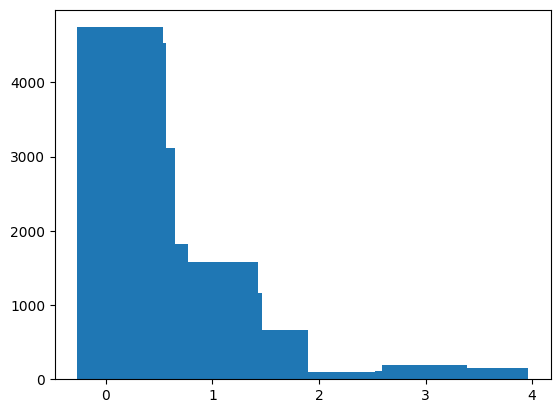

In [63]:
plt.bar(analysis_df['loss'].values, analysis_df['num_samples'].values)

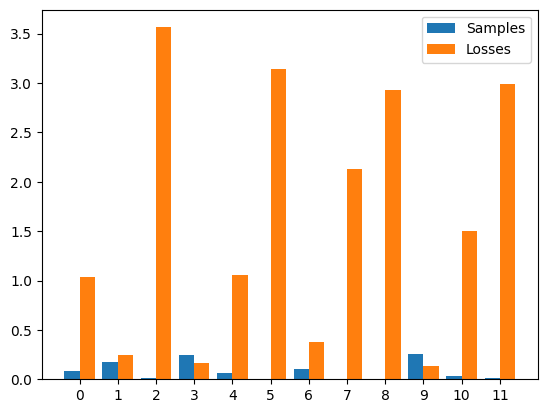

In [70]:
X = [x for x in range(12)]
num_samples_ = analysis_df['num_samples'].values / np.sum(analysis_df['num_samples'].values)
loss_ = analysis_df['loss'].values
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, num_samples_, 0.4, label = 'Samples') 
plt.bar(X_axis + 0.2, loss_, 0.4, label = 'Losses') 
  
plt.xticks(X_axis, X) 
# plt.xlabel("Class") 
# plt.ylabel("Number of Students") 
# plt.title("Number of Students in each group") 
plt.legend() 
plt.show()

In [ ]:
# classes with max loss -> 0, 2, 5, 7, 8, 10, 11

In [20]:
# model = get_model(12)
# model.load_state_dict(torch.load('../../weights/res32_horizontal_flip_random_rotate_norm/33.h5'))

In [5]:
data_object = temp.get_object()
loader_object = GetLoaders(data_object.train, data_object.val, data_object.test)
loader_object.create_sets()
loader_object.create_loaders(shuffle_train=False, batch_size=256)
train_loader, val_loader, test_loader = loader_object.return_loaders()

In [9]:
# Eval on test set
eval_dataset(get_model(12), val_loader, '../../weights/res32_horizontal_flip_random_rotate_norm/23.pth')

tensor(0.4868, device='cuda:0')

In [10]:
# Eval on test set
eval_dataset(get_model(12), test_loader, '../../weights/res32_horizontal_flip_random_rotate_norm/23.pth')

tensor(0.6752, device='cuda:0')

In [69]:
# Eval on test set
loss, preds = eval_dataset(get_model(12), train_loader, '../../weights/res32_horizontal_flip_random_rotate_norm/23.pth', return_preds=True)

In [147]:
c_m, precision, recall = generate_metrics(preds, torch.Tensor(train_loader.dataset.labels).long(), num_classes=12)

## Training with selected classes with training

In [4]:
temp = ReadCSV('../../plant_path_data/train.csv', '../../plant_path_data/train_images_224/')
temp.read_csv()
temp.check_paths()
temp.encode_labels()
temp.one_hot_encoder()
temp.split_datasets()

In [5]:
data_object = temp.get_object()
loader_object = GetLoaders(data_object.train, data_object.val, data_object.test)
loader_object.create_sets()
loader_object.create_loaders(batch_size=256)
train_loader, val_loader, test_loader = loader_object.return_loaders()

In [6]:
wandb_dict = {
    'model_name' : 'res50',
    'dataset_name' : 'plant_pathology',
    'epochs' : 50,
    'batch_size' : 256,
    'learning_rate' : 0.001,
    'optimizer' : 'Adam',
    'weights_path' : '../../weights/res50_horizontal_flip_random_brightness_contrast/',
    'horizontal_flip' : True,
    'random_rotation' : True,
    'normalize' : True,
    'color_jitter' : True,
    # 'selected_classes' : [0, 2, 5, 7, 8, 10, 11]
}

In [8]:
model = torchvision.models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 12)

In [9]:
train(model, train_loader, val_loader, 50, wandb_dict=wandb_dict, save_path='../../weights/res50_horizontal_flip_random_brightness_contrast/')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yashchks87. Use `wandb login --relogin` to force relogin


100%|██████████| 72/72 [00:31<00:00,  2.28batch/s, loss=1.6] 


train loss: 1.8913254588842392


100%|██████████| 1/1 [00:01<00:00,  1.37s/batch, loss=1.98]


val loss: 1.9812206029891968
Weight saved for epoch 0.


100%|██████████| 72/72 [00:28<00:00,  2.57batch/s, loss=1.73]


train loss: 1.7067578004466162


100%|██████████| 1/1 [00:01<00:00,  1.56s/batch, loss=1.62]


val loss: 1.618816614151001
Weight saved for epoch 1.


100%|██████████| 72/72 [00:28<00:00,  2.56batch/s, loss=0.965]


train loss: 1.4733862305680911


100%|██████████| 1/1 [00:01<00:00,  1.39s/batch, loss=1.32]


val loss: 1.3234155178070068
Weight saved for epoch 2.


100%|██████████| 72/72 [00:28<00:00,  2.55batch/s, loss=1.26]


train loss: 1.230275387565295


100%|██████████| 1/1 [00:01<00:00,  1.40s/batch, loss=1.07]


val loss: 1.0720523595809937
Weight saved for epoch 3.


100%|██████████| 72/72 [00:28<00:00,  2.53batch/s, loss=0.884]


train loss: 1.0877438866429858


100%|██████████| 1/1 [00:01<00:00,  1.48s/batch, loss=1.05]


val loss: 1.0467106103897095
Weight saved for epoch 4.


100%|██████████| 72/72 [00:28<00:00,  2.55batch/s, loss=1.09] 


train loss: 0.9794333875179291


100%|██████████| 1/1 [00:01<00:00,  1.43s/batch, loss=0.916]


val loss: 0.9156414270401001
Weight saved for epoch 5.


100%|██████████| 72/72 [00:28<00:00,  2.53batch/s, loss=0.719]


train loss: 0.8736714132957988


100%|██████████| 1/1 [00:01<00:00,  1.50s/batch, loss=0.977]


val loss: 0.9765582084655762
Weight saved for epoch 6.


100%|██████████| 72/72 [00:28<00:00,  2.54batch/s, loss=0.932]


train loss: 0.8126905494266086


100%|██████████| 1/1 [00:01<00:00,  1.39s/batch, loss=0.847]


val loss: 0.847040593624115
Weight saved for epoch 7.


100%|██████████| 72/72 [00:28<00:00,  2.56batch/s, loss=0.626]


train loss: 0.746454248825709


100%|██████████| 1/1 [00:01<00:00,  1.47s/batch, loss=0.735]


val loss: 0.7345107793807983
Weight saved for epoch 8.


100%|██████████| 72/72 [00:28<00:00,  2.54batch/s, loss=0.573]


train loss: 0.7086496965752708


100%|██████████| 1/1 [00:01<00:00,  1.39s/batch, loss=0.842]


val loss: 0.8419942259788513
Weight saved for epoch 9.


100%|██████████| 72/72 [00:28<00:00,  2.54batch/s, loss=0.657]


train loss: 0.6793958875868056


100%|██████████| 1/1 [00:01<00:00,  1.51s/batch, loss=0.737]


val loss: 0.7374329566955566
Weight saved for epoch 10.


100%|██████████| 72/72 [00:28<00:00,  2.53batch/s, loss=0.926]


train loss: 0.6649995090232955


100%|██████████| 1/1 [00:01<00:00,  1.55s/batch, loss=0.679]


val loss: 0.6785129308700562
Weight saved for epoch 11.


100%|██████████| 72/72 [00:28<00:00,  2.52batch/s, loss=0.592]


train loss: 0.6354867145419121


100%|██████████| 1/1 [00:01<00:00,  1.50s/batch, loss=0.66]


val loss: 0.6602321863174438
Weight saved for epoch 12.


100%|██████████| 72/72 [00:28<00:00,  2.53batch/s, loss=0.512]


train loss: 0.6093420489794679


100%|██████████| 1/1 [00:01<00:00,  1.48s/batch, loss=0.692]


val loss: 0.6923892498016357
Weight saved for epoch 13.


100%|██████████| 72/72 [00:28<00:00,  2.54batch/s, loss=0.681]


train loss: 0.6083251246147685


100%|██████████| 1/1 [00:01<00:00,  1.54s/batch, loss=0.938]


val loss: 0.9383658766746521
Weight saved for epoch 14.


100%|██████████| 72/72 [00:28<00:00,  2.55batch/s, loss=0.528]


train loss: 0.5910474310318629


100%|██████████| 1/1 [00:01<00:00,  1.49s/batch, loss=0.643]


val loss: 0.6430179476737976
Weight saved for epoch 15.


100%|██████████| 72/72 [00:28<00:00,  2.56batch/s, loss=0.39] 


train loss: 0.5865234546363354


100%|██████████| 1/1 [00:01<00:00,  1.58s/batch, loss=0.738]


val loss: 0.7379838228225708
Weight saved for epoch 16.


100%|██████████| 72/72 [00:28<00:00,  2.50batch/s, loss=0.355]


train loss: 0.5628737749324905


100%|██████████| 1/1 [00:01<00:00,  1.50s/batch, loss=0.645]


val loss: 0.6447267532348633
Weight saved for epoch 17.


100%|██████████| 72/72 [00:28<00:00,  2.53batch/s, loss=0.584]


train loss: 0.5537737508614858


100%|██████████| 1/1 [00:01<00:00,  1.52s/batch, loss=0.561]


val loss: 0.5605323910713196
Weight saved for epoch 18.


100%|██████████| 72/72 [00:28<00:00,  2.54batch/s, loss=0.514]


train loss: 0.5373691444595655


100%|██████████| 1/1 [00:01<00:00,  1.51s/batch, loss=0.694]


val loss: 0.6942273378372192
Weight saved for epoch 19.


100%|██████████| 72/72 [00:28<00:00,  2.55batch/s, loss=0.581]


train loss: 0.5311975313557519


100%|██████████| 1/1 [00:01<00:00,  1.56s/batch, loss=0.61]


val loss: 0.6095691323280334
Weight saved for epoch 20.


100%|██████████| 72/72 [00:28<00:00,  2.54batch/s, loss=0.384]


train loss: 0.5212137661874294


100%|██████████| 1/1 [00:01<00:00,  1.55s/batch, loss=0.563]


val loss: 0.5630370378494263
Weight saved for epoch 21.


100%|██████████| 72/72 [00:28<00:00,  2.53batch/s, loss=0.655]


train loss: 0.5120125528838899


100%|██████████| 1/1 [00:01<00:00,  1.57s/batch, loss=0.577]


val loss: 0.5772800445556641
Weight saved for epoch 22.


100%|██████████| 72/72 [00:28<00:00,  2.55batch/s, loss=0.634]


train loss: 0.5080664936039183


100%|██████████| 1/1 [00:01<00:00,  1.54s/batch, loss=0.609]


val loss: 0.6089910864830017
Weight saved for epoch 23.


100%|██████████| 72/72 [00:28<00:00,  2.55batch/s, loss=0.548]


train loss: 0.4937873346110185


100%|██████████| 1/1 [00:01<00:00,  1.54s/batch, loss=0.566]


val loss: 0.5662009716033936
Weight saved for epoch 24.


100%|██████████| 72/72 [00:28<00:00,  2.57batch/s, loss=0.39] 


train loss: 0.49447961896657944


100%|██████████| 1/1 [00:01<00:00,  1.52s/batch, loss=0.725]


val loss: 0.7250447869300842
Weight saved for epoch 25.


100%|██████████| 72/72 [00:28<00:00,  2.55batch/s, loss=0.397]


train loss: 0.4866528879437182


100%|██████████| 1/1 [00:01<00:00,  1.56s/batch, loss=0.77]


val loss: 0.7698323130607605
Weight saved for epoch 26.


100%|██████████| 72/72 [00:28<00:00,  2.54batch/s, loss=0.562]


train loss: 0.46188462856743073


100%|██████████| 1/1 [00:01<00:00,  1.51s/batch, loss=0.54]


val loss: 0.539712131023407
Weight saved for epoch 27.


100%|██████████| 72/72 [00:28<00:00,  2.55batch/s, loss=0.581]


train loss: 0.47822220126787823


100%|██████████| 1/1 [00:01<00:00,  1.51s/batch, loss=0.695]


val loss: 0.6950557231903076
Weight saved for epoch 28.


100%|██████████| 72/72 [00:28<00:00,  2.54batch/s, loss=0.463]


train loss: 0.45455876365303993


100%|██████████| 1/1 [00:01<00:00,  1.49s/batch, loss=0.694]


val loss: 0.6942570209503174
Weight saved for epoch 29.


100%|██████████| 72/72 [00:28<00:00,  2.52batch/s, loss=0.583]


train loss: 0.4628474588195483


100%|██████████| 1/1 [00:01<00:00,  1.61s/batch, loss=0.684]


val loss: 0.6842870116233826
Weight saved for epoch 30.


100%|██████████| 72/72 [00:28<00:00,  2.50batch/s, loss=0.391]


train loss: 0.4529250164826711


100%|██████████| 1/1 [00:01<00:00,  1.59s/batch, loss=0.536]


val loss: 0.5359418392181396
Weight saved for epoch 31.


100%|██████████| 72/72 [00:28<00:00,  2.54batch/s, loss=0.356]


train loss: 0.45158611941668725


100%|██████████| 1/1 [00:01<00:00,  1.58s/batch, loss=0.576]


val loss: 0.576396644115448
Weight saved for epoch 32.


100%|██████████| 72/72 [00:28<00:00,  2.56batch/s, loss=0.415]


train loss: 0.4418799645370907


100%|██████████| 1/1 [00:01<00:00,  1.52s/batch, loss=0.529]


val loss: 0.5290322303771973
Weight saved for epoch 33.


100%|██████████| 72/72 [00:28<00:00,  2.51batch/s, loss=0.375]


train loss: 0.43525998791058856


100%|██████████| 1/1 [00:01<00:00,  1.52s/batch, loss=0.573]


val loss: 0.57322096824646
Weight saved for epoch 34.


100%|██████████| 72/72 [00:27<00:00,  2.57batch/s, loss=0.519]


train loss: 0.4267797064450052


100%|██████████| 1/1 [00:01<00:00,  1.52s/batch, loss=0.615]


val loss: 0.6149920225143433
Weight saved for epoch 35.


100%|██████████| 72/72 [00:28<00:00,  2.53batch/s, loss=0.275]


train loss: 0.4291098713874817


100%|██████████| 1/1 [00:01<00:00,  1.59s/batch, loss=0.546]


val loss: 0.5457122921943665
Weight saved for epoch 36.


100%|██████████| 72/72 [00:28<00:00,  2.53batch/s, loss=0.403]


train loss: 0.427805296662781


100%|██████████| 1/1 [00:01<00:00,  1.51s/batch, loss=0.543]


val loss: 0.5425695180892944
Weight saved for epoch 37.


100%|██████████| 72/72 [00:28<00:00,  2.56batch/s, loss=0.45] 


train loss: 0.4137330146299468


100%|██████████| 1/1 [00:01<00:00,  1.54s/batch, loss=0.572]


val loss: 0.5721267461776733
Weight saved for epoch 38.


100%|██████████| 72/72 [00:28<00:00,  2.53batch/s, loss=0.521]


train loss: 0.4107772062222163


100%|██████████| 1/1 [00:01<00:00,  1.57s/batch, loss=0.517]


val loss: 0.5165425539016724
Weight saved for epoch 39.


100%|██████████| 72/72 [00:28<00:00,  2.54batch/s, loss=0.324]


train loss: 0.4018174161513646


100%|██████████| 1/1 [00:01<00:00,  1.49s/batch, loss=0.52]


val loss: 0.5203101634979248
Weight saved for epoch 40.


100%|██████████| 72/72 [00:28<00:00,  2.57batch/s, loss=0.38] 


train loss: 0.39833662907282513


100%|██████████| 1/1 [00:01<00:00,  1.64s/batch, loss=0.638]


val loss: 0.6384393572807312
Weight saved for epoch 41.


100%|██████████| 72/72 [00:28<00:00,  2.56batch/s, loss=0.775]


train loss: 0.3962021664612823


100%|██████████| 1/1 [00:01<00:00,  1.54s/batch, loss=0.586]


val loss: 0.586376965045929
Weight saved for epoch 42.


100%|██████████| 72/72 [00:28<00:00,  2.56batch/s, loss=0.599]


train loss: 0.3943169741994805


100%|██████████| 1/1 [00:01<00:00,  1.56s/batch, loss=0.47]


val loss: 0.47032925486564636
Weight saved for epoch 43.


100%|██████████| 72/72 [00:28<00:00,  2.54batch/s, loss=0.352]


train loss: 0.3812479128440221


100%|██████████| 1/1 [00:01<00:00,  1.53s/batch, loss=0.493]


val loss: 0.4933629631996155
Weight saved for epoch 44.


100%|██████████| 72/72 [00:28<00:00,  2.54batch/s, loss=0.319]


train loss: 0.3763173644741376


100%|██████████| 1/1 [00:01<00:00,  1.52s/batch, loss=0.477]


val loss: 0.47723859548568726
Weight saved for epoch 45.


100%|██████████| 72/72 [00:28<00:00,  2.54batch/s, loss=0.362]


train loss: 0.36650651651952004


100%|██████████| 1/1 [00:01<00:00,  1.52s/batch, loss=0.498]


val loss: 0.49780896306037903
Weight saved for epoch 46.


100%|██████████| 72/72 [00:28<00:00,  2.56batch/s, loss=0.37] 


train loss: 0.3618073844247394


100%|██████████| 1/1 [00:01<00:00,  1.52s/batch, loss=0.726]


val loss: 0.7258797883987427
Weight saved for epoch 47.


100%|██████████| 72/72 [00:28<00:00,  2.51batch/s, loss=0.31] 


train loss: 0.3737279950744576


100%|██████████| 1/1 [00:01<00:00,  1.52s/batch, loss=0.531]


val loss: 0.5308825969696045
Weight saved for epoch 48.


100%|██████████| 72/72 [00:28<00:00,  2.53batch/s, loss=0.38] 


train loss: 0.3601777743962076


100%|██████████| 1/1 [00:01<00:00,  1.50s/batch, loss=0.481]


val loss: 0.4808189570903778
Weight saved for epoch 49.


## Training with augmentation and label smoothing

In [2]:
temp = ReadCSV('../../plant_path_data/train.csv', '../../plant_path_data/train_images_224/')
temp.read_csv()
temp.check_paths()
temp.encode_labels()
temp.one_hot_encoder()
temp.split_datasets()

In [3]:
data_object = temp.get_object()
loader_object = GetLoaders(data_object.train, data_object.val, data_object.test)
loader_object.create_sets()
loader_object.create_loaders(batch_size=256)
train_loader, val_loader, test_loader = loader_object.return_loaders()

In [4]:
wandb_dict = {
    'model_name' : 'res32',
    'dataset_name' : 'plant_pathology',
    'epochs' : 50,
    'batch_size' : 256,
    'learning_rate' : 0.001,
    'optimizer' : 'Adam',
    'weights_path' : '../../weights/res50_horizontal_flip_random_brightness_contrast_smoothing/',
    'horizontal_flip' : True,
    'random_rotation' : True,
    'normalize' : True,
    'color_jitter' : True,
    'label_smoothing' : 0.1,
    # 'selected_classes' : [0, 2, 5, 7, 8, 10, 11]
}

In [ ]:
train(get_model(12), train_loader, val_loader, 50, wandb_dict=wandb_dict, save_path='../../weights/res50_horizontal_flip_random_brightness_contrast_smoothing/')